# Active Learning in Small-Text with Argilla 

*Notebook 5*

In this tutorial, we demonstrate how to use a small‑text active‑learning approach in combination with the [Argilla](https://argilla.io/) web interface. It uses a SetFit‑based classifier.

## Overview

- [Part I: Installation](#nb5-part1-installation)
- [Part II: Data Preparation](#nb5-part2-data)
- [Part III: Active Learning](#nb5-part3-al)
- [Part IV: Evaluation](#nb5-part4-eval)

<a id="nb5-part1-installation"></a>
## I Installation

### Small-Text

In [ ]:
%pip install small-text[transformers]==2.0.0dev3
# setfit is used as an optional dependency here
%pip install setfit==1.1.2
%pip install datasets==3.5.0

In [ ]:
import datasets

### Argilla

To be able to use the Argilla interface for active learning, we need a running Argilla instance. It can be started locally or provided by someone else over the network. Argilla provides two ways to get such an instance up and running:

1. [Using Hugging Face Spaces](https://docs.argilla.io/latest/getting_started/quickstart/). For this you don't need to install additional software on your computer, but a Hugging Face Account is required.
2. [Using Docker](https://docs.argilla.io/latest/getting_started/how-to-deploy-argilla-with-docker/). This allows for local deployments on your machine, but requires a [docker engine](https://docs.docker.com/get-started/get-docker/) on your machine.

In the following, we assume that an Argilla instance is running locally at [http://localhost:6900 ](http://localhost:6900). In case you are using Hugging Face, you need to update the link to your space accordingly (see the [docs](https://docs.argilla.io/latest/getting_started/quickstart/#create-your-first-dataset)).

In [3]:
# %pip install argilla
import argilla as rg

# connect to your Argilla instance
client = rg.Argilla(
    api_url="http://localhost:6900", 
    api_key="argilla.apikey" # default key in docker-compose script
)

<a id="nb5-part2-data"></a>
# II Data

We use the "AG's News" dataset for this demonstration. It consists of news articles which are categorized into four mutually exclusive classes.

In [4]:
raw_dataset = datasets.load_dataset('ag_news')

print('First 5 training samples:\n')
for i in range(5):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

First 5 training samples:

2   Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
2   Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
2   Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
2   Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday.
2   Oil prices soar to all-time record, posing new mena

### Preparing the Data

The SetFit Classifier uses the `TextData` structure as input. Such datasets can be easily created from raw text and labels using `TextDataset.from_arrays()`.

In [5]:
import numpy as np
from small_text import TextDataset

num_classes = raw_dataset['train'].features['label'].num_classes

target_labels = np.arange(num_classes)

train = TextDataset.from_arrays(raw_dataset['train']['text'], np.array(raw_dataset['train']['label']), target_labels=target_labels)
test = TextDataset.from_arrays(raw_dataset['test']['text'], np.array(raw_dataset['test']['label']), target_labels=target_labels)

In [6]:
label_mapping = {'World': 0,
                 'Sports': 1,
                 'Business': 2,
                 'Sci/Tech': 3}

### Initialzing the Data in Argilla

In Argilla we need to intialize the structure of our data once before we can push data to our Instance. To change the structure later a reinitialization is required.

In [8]:
# Choose a name for the dataset
DATASET_NAME = f"ags-news-active-learning"

# Define labeling schema
settings = rg.Settings(
    guidelines="Argilla Test",
    fields=[
      # Text to be labeld
      rg.TextField(
        name = "newsText",
        title = "News Text.",
        use_markdown=False,
      )
    ],
    questions=[
      rg.LabelQuestion(
          name="label",
          title="What category does the article belong to?",
          labels=list(label_mapping.keys()),
      ),
    ],
    metadata=[
        # later we only want to train on the latest batches
        rg.IntegerMetadataProperty(
            name="batch_id",
            min=0,
            max=1000,
            title="batch_id"
        ),
    ],
)

# Create dataset with a label schema
dataset = rg.Dataset(
    name=DATASET_NAME,
    settings=settings,
)
dataset.create()

Dataset(id=UUID('6ffcdaed-a35b-4232-bb7b-72ae44d499b7') inserted_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 150319) updated_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 269924) name='ags-news-active-learning' status='ready' guidelines='Argilla Test' allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('c0cca5f2-fd97-4375-8f7c-61e05c36dccc') last_activity_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 269924))

<a id="nb5-part3-al"></a>
## III Active Learning

### Configuring the Classifier

In [9]:
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory

num_classes = 4

sentence_transformer_model_name = 'sentence-transformers/paraphrase-mpnet-base-v2' 
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name, show_progress_bar=False)
clf_factory = SetFitClassificationFactory(setfit_model_args, num_classes)

### Setting up the Active Learner

Here, we construct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 20 sentences. This corresponds to an initial labeling in the real-world setting. The initial labels could also be obtained via Argilla, applying the same logic that will be demonstrated by the following code.

In [10]:
from small_text import (
    PoolBasedActiveLearner, 
    random_initialization_balanced,
    BreakingTies,
    SubsamplingQueryStrategy
)

# define a query strategy and initialize a pool-based active learner
query_strategy = SubsamplingQueryStrategy(BreakingTies())
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)


# simulate a warm start
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize(indices_initial)

    return indices_initial


initial_indices = initialize_active_learner(active_learner, train.y)
labeled_indices = initial_indices

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Map: 100%|██████████| 20/20 [00:00<00:00, 3225.40 examples/s]
***** Running training *****
  Num unique pairs = 300
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.351400


### Evaluation Strategy

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next. We then provide the labels for those documents and the active learner retrains the model. After each query, we evaluate the current model against the test set and save the result.

In [11]:
import gc
import torch
from sklearn.metrics import accuracy_score

current_batch_id = 0

def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print(f'Train accuracy: {accuracy_score(y_pred, train.y):.2f}')
    print(f'Test accuracy: {test_acc:.2f}')
    
    return test_acc


results_setfit = []
results_setfit.append(evaluate(active_learner, train[labeled_indices], test))

Train accuracy: 1.00
Test accuracy: 0.81


### Active Learning Loop

In each iteration, all queried examples must be labeld inside Argilla. 

In [12]:
# Helper function to map the answer codes back to the numerical labels 
def get_answr_codes(records):
    
    y_label = [record["label.responses"] for record in records]
    y = [label_mapping[label[0]] for label in y_label]
    
    return y

The two following cells will be executed in sequence as long as you want to keep training your classifier. Each time you execute the first cell, you need to move over to Argilla to annotate the current batch. If you have labeled all examples, you can retrain the classifier, and so on. For intermediate evaluations, you can execute the code in the next section to see how well your classifier performs already.

*Logging the current batch to Argilla for Annotation.*

In [17]:
# ...where each iteration consists of labelling 20 samples
q_indices = active_learner.query(num_samples=20)

records = [
    rg.Record(
        fields={
            "newsText": row.get("text", "")
        },
        metadata={"batch_id": current_batch_id}
    )
    for i, row in enumerate(raw_dataset["train"])       # stream rows
    if i in q_indices                                   # keep only wanted rows
]

# keep record ids to reconstruct original order on retrieve
rec_ids = [str(rec.id) for rec in records]

# Log records to Argilla
dataset.records.log(records)

DatasetRecords: The provided batch size 256 was normalized. Using value 20.

Sending records...: 100%|██████████| 1/1 [00:00<00:00,  3.12batch/s]


DatasetRecords(Dataset(id=UUID('6ffcdaed-a35b-4232-bb7b-72ae44d499b7') inserted_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 150319) updated_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 269924) name='ags-news-active-learning' status='ready' guidelines='Argilla Test' allow_extra_metadata=False distribution=OverlapTaskDistributionModel(strategy='overlap', min_submitted=1) workspace_id=UUID('c0cca5f2-fd97-4375-8f7c-61e05c36dccc') last_activity_at=datetime.datetime(2025, 9, 17, 11, 50, 49, 269924)))

*Retraining the Classifier*

In [18]:
# retrieve annotated examples
status_filter = rg.Query(filter=rg.Filter([("response.status", "==", "submitted"),
                                           ("metadata.batch_id", "==", current_batch_id)]))
submitted_list = dataset.records(status_filter).to_list(flatten=True)

# restore original ordering
record_lookup = {rec['id']: rec for rec in submitted_list} 
ordered_records = [record_lookup[str(uid)] for uid in rec_ids if str(uid) in record_lookup]

# mapping labels to numbers 
y = np.array(get_answr_codes(ordered_records))

# Return the labels for the current query to the active learner.
active_learner.update(y)

# memory fix: https://github.com/UKPLab/sentence-transformers/issues/1793
gc.collect()
torch.cuda.empty_cache()

labeled_indices = np.concatenate([q_indices, labeled_indices])

current_batch_id+=1

print('---------------')
print(f'Iteration #{i:d} ({len(labeled_indices)} samples)')
results_setfit.append(evaluate(active_learner, train[labeled_indices], test))

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Map: 100%|██████████| 80/80 [00:00<00:00, 7717.74 examples/s]
***** Running training *****
  Num unique pairs = 4738
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.123500
50,0.268400
100,0.182000
150,0.098000
200,0.011500
250,0.002600


---------------
Iteration #4 (80 samples)
Train accuracy: 0.49
Test accuracy: 0.43


<a id="nb5-part4-eval"></a>
## IV Evaluation

Text(0.5, 0, 'number of batches')

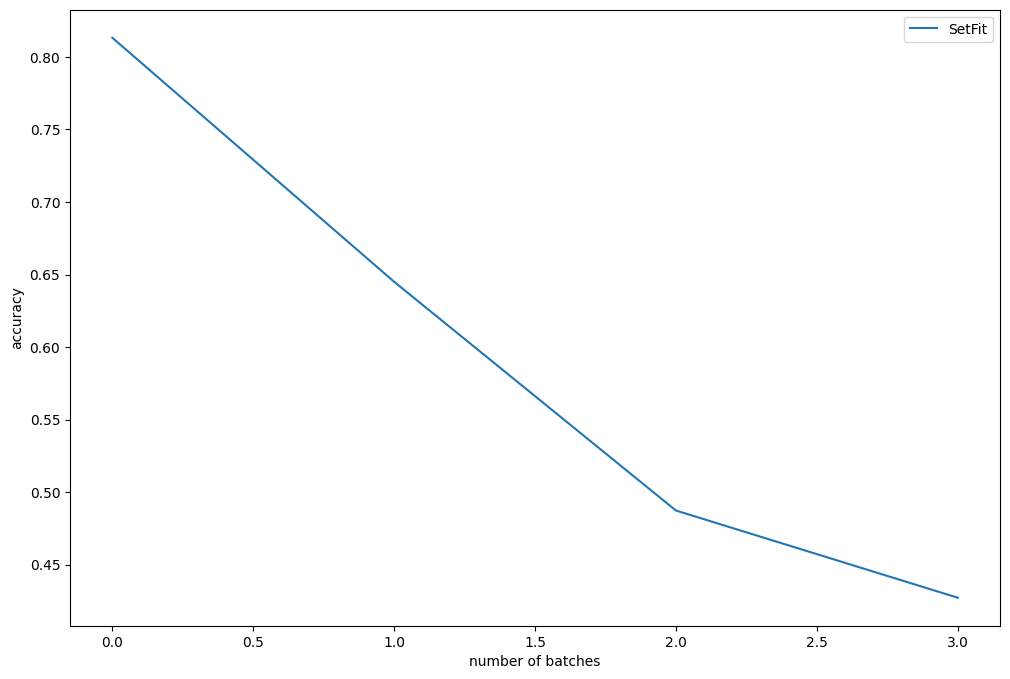

In [35]:
#%matplotlib inline
import matplotlib.pyplot as plt;

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(np.arange(current_batch_id+1), results_setfit, label='SetFit')
ax.legend()

plt.ylabel('accuracy')
plt.xlabel('number of batches')

display(plt)

In [45]:
%pip freeze

accelerate==1.6.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.16
aiosignal==1.3.2
annotated-types==0.7.0
anyio==4.9.0
argilla==2.8.0
asttokens==3.0.0
async-timeout==5.0.1
attrs==25.3.0
certifi==2025.1.31
charset-normalizer==3.4.1
comm==0.2.2
contourpy==1.3.2
cycler==0.12.1
datasets==3.5.0
debugpy==1.8.14
decorator==5.2.1
Deprecated==1.2.18
dill==0.3.8
evaluate==0.4.3
exceptiongroup==1.2.2
executing==2.2.0
filelock==3.18.0
fonttools==4.57.0
frozenlist==1.5.0
fsspec==2024.12.0
h11==0.14.0
httpcore==1.0.8
httpx==0.28.1
huggingface-hub==0.30.2
idna==3.10
ipykernel==6.29.5
ipython==8.35.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
markdown-it-py==3.0.0
MarkupSafe==3.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
mdurl==0.1.2
mpmath==1.3.0
multidict==6.4.3
multiprocess==0.70.16
nest-asyncio==1.6.0
networkx==3.4.2
numpy==1.26.4
nvidia-cublas-cu12==12.4.5.8
nvidia-cuda-cupti-cu12==12.4.127
nvidia-cuda-nvrtc-cu12==12.4.127
nvidia-cuda-runtime